In [179]:
import numpy as np
import matplotlib.pyplot as plt
import graph_tool.all as gt
from numpy.random import *
from time import perf_counter
import matplotlib.gridspec as gridspec

Helpers for creating random graphs

In [84]:
def sample_k(max):
    accept = False
    while not accept:
        k = np.random.randint(1,max+1)
        accept = np.random.random() < 1.0/k
    return k

def get_random_graph_of_size(nodes):
    # g = gt.random_graph(1000, lambda: sample_k(40), model="probabilistic-configuration",
    #                     edge_probs=lambda i, k: 1.0 / (1 + abs(i - k)), directed=False,
    #                     n_iter=100)
    return gt.random_graph(nodes, lambda: (sample_k(40), sample_k(40)), directed=True, n_iter=100)

Code for performing random walks on a graph, as we would do to compute the H-path feature in the HAS-embedding model.  
Including a couple iterations of trying to make performance improvements.

In [177]:
# Random walk
def random_walk1(g, start_node, walk_length=10):
    v = g.vertex(start_node)
    walk = [int(v)]
    while len(walk) < walk_length:
        if v.out_degree() == 0:
            break
        n_list = []
        for w in v.out_neighbors():
            n_list.append(w)
        v = n_list[randint(0, len(n_list))]
        walk.append(int(v))
    return walk

def random_walk2(g, start_node, walk_length=10):
    v = start_node
    walk = [int(v)]
    while len(walk) < walk_length:
        if g.get_out_degrees([v]) == 0:
            break
        n_list = g.get_out_neighbors(v)
        v = n_list[randint(0, len(n_list))]
        walk.append(int(v))
    return walk

def random_walk3(g, start_nodes, walk_length=10):
    # pre-allocate walks array with initial values of -1
    walks = np.ones((len(start_nodes),walk_length), dtype=int) * -1
    
    walks[:,0] = start_nodes
    cur_length = 1
    while cur_length < walk_length:
        cur_nodes = walks[:,cur_length - 1]
        # if we've previously hit a dead end, then we could have -1 as a 
        # current node value in this case, we want to continue filling in -1.
        neighbors = [np.array([-1]) if v < 0 else g.get_out_neighbors(v) for v in cur_nodes]
        # if there are no outbound edges we can take for 
        # some vertex, we'll make the next vertex we visit = -1
        neighbors = [np.arrray([-1]) if len(arr) < 0 else arr for arr in neighbors]
        next_nodes = [np.random.choice(arr) for arr in neighbors]
        walks[:,cur_length] = next_nodes
        cur_length += 1
    return walks

# Performs num_walks random walks at each node in the graph
# i.e. if there are 10 nodes in the gaph and num_walks=10, then we'll do 10*10 = 100 random walks.
# Returns a list of walks
def build_corpus1(g, walk_length=10, num_walks=10):
    walks = [random_walk1(g, start) for start in g.get_vertices() for i in range(num_walks)]
    return walks
def build_corpus2(g, walk_length=10, num_walks=10):
    walks = [random_walk2(g, start) for start in g.get_vertices() for i in range(num_walks)]
    return walks
def build_corpus3(g, walk_length=10, num_walks=10):
    start_nodes = np.repeat(g.get_vertices(), num_walks)
    walks = random_walk3(g, start_nodes)
    return walks

Seeing if DFS can be made to do random walk by customizing the search events...  
See below that running the cell that does the DFS gives the same path every time - there doesn't seem to be a way to make it choose which neighbor to go to in a non-deterministic fashion.

In [165]:
g = get_random_graph_of_size(5)

In [166]:
class Visitor(gt.DFSVisitor):

    def __init__(self, step_num, max_step):
        self.step_num = step_num
        self.cur_step = 0
        self.max_step = max_step

    def discover_vertex(self, u):
        print("-->", int(u), "has been discovered!")
        self.step_num[u] = self.cur_step
        self.cur_step += 1
        if self.cur_step >= self.max_step:
            raise gt.StopSearch()
step_num = g.new_vertex_property("int")
gt.dfs_search(g, g.vertex(0), Visitor(step_num, 4))
print(step_num.a)

--> 0 has been discovered!
--> 2 has been discovered!
--> 1 has been discovered!
--> 3 has been discovered!
[0 2 1 3 0]


Let's look at how the time to perform the random walks scales with the size of the graph

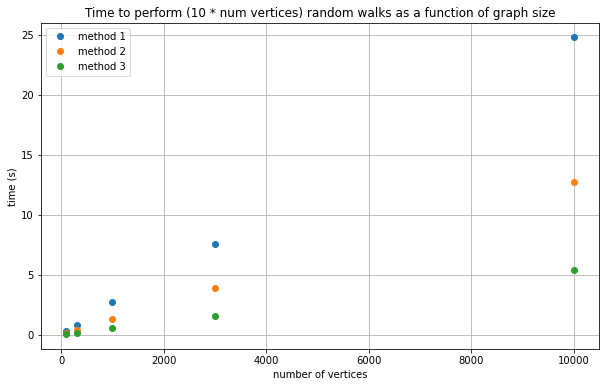

In [193]:
sizes = [100, 300, 1000, 3000, 10000]
times1 = []
times2 = []
times3 = []
for size in sizes:
    g = get_random_graph_of_size(size)
    
    start = perf_counter()
    walks = build_corpus1(g)
    stop = perf_counter()
    times1.append(stop-start)
    
    start = perf_counter()
    walks = build_corpus2(g)
    stop = perf_counter()
    times2.append(stop-start)
    
    start = perf_counter()
    walks = build_corpus3(g)
    stop = perf_counter()
    times3.append(stop-start)
    
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(sizes, times1, 'o', label="method 1")
ax.plot(sizes, times2, 'o', label="method 2")
ax.plot(sizes, times3, 'o', label="method 3")

ax.set(xlabel='number of vertices', ylabel='time (s)',
       title='Time to perform (10 * num vertices) random walks as a function of graph size')
ax.grid()
ax.legend()

plt.show()